# Importing Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path

import utils.utils as utils
import utils.models as models

from tensorflow.keras import callbacks
try:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH  = os.path.join('drive', 'My Drive', 'Artificial Intelligence in Industry', 'project')
except:
  PATH = str(Path(os.getcwd()).parent)

figsize=(14, 5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Improve usage of unsupervised data for the definition of RUL-based maintenance policies

## Data Loading and Preparation

In [2]:
path = os.path.join(PATH, 'data','CMAPSS')

data = utils.load_cmapss_data(path, 'train_*.txt')

# Identify input columns
dt_in = list(data.columns[3:-1])


**C-MAPSS stands for 'Commercial Modular Aero-Propulsion System Simulation'**.
* It is a tool for the simulation of realistic large commercial turbofan engine data.
* The dataset consists of 4 training set files and 4 test set files.
* The training set files contain multiple run-to-failure experiments.
* The test set files contain truncated experiments.


In [3]:
data_by_src = utils.split_by_field(data, field='src')
dt = data_by_src['train_FD004']
dt[dt_in] = dt[dt_in].astype(np.float32)
dt.head() # The head() method returns top n rows of a DataFrame or Series where n is a user input value.

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.004902,0.8400,100.0,445.000000,549.679993,1343.430054,1112.930054,...,2387.989990,8074.830078,9.3335,0.02,330.0,2212.0,100.00,10.620000,6.3670,320
1,train_FD004,461,2,20.002001,0.7002,100.0,491.190002,606.070007,1477.609985,1237.500000,...,2387.729980,8046.129883,9.1913,0.02,361.0,2324.0,100.00,24.370001,14.6552,319
2,train_FD004,461,3,42.003799,0.8409,100.0,445.000000,548.950012,1343.119995,1117.050049,...,2387.969971,8066.620117,9.4007,0.02,329.0,2212.0,100.00,10.480000,6.4213,318
3,train_FD004,461,4,42.000000,0.8400,100.0,445.000000,548.700012,1341.239990,1118.030029,...,2388.020020,8076.049805,9.3369,0.02,328.0,2212.0,100.00,10.540000,6.4176,317
4,train_FD004,461,5,25.006300,0.6207,60.0,462.540009,536.099976,1255.229980,1033.589966,...,2028.079956,7865.799805,10.8366,0.02,305.0,1915.0,84.93,14.030000,8.6754,316


In [4]:
# The shape method in Pandas returns a tuple representing the dimensions i.e. (rows & columns) of the DataFrame.
dt.shape

(61249, 28)

In [5]:
# display the columns of the datset
dt.columns

Index(['src', 'machine', 'cycle', 'p1', 'p2', 'p3', 's1', 's2', 's3', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15',
       's16', 's17', 's18', 's19', 's20', 's21', 'rul'],
      dtype='object')

* The Dataset contains Columns "p1, p2, p3" refer to controlled parameters and the Columns "s1" to "s21" refer to sensor readings.

## Data Inspecting 

In [6]:
# The info() function prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61249 entries, 0 to 61248
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   src      61249 non-null  object 
 1   machine  61249 non-null  int64  
 2   cycle    61249 non-null  int64  
 3   p1       61249 non-null  float32
 4   p2       61249 non-null  float32
 5   p3       61249 non-null  float32
 6   s1       61249 non-null  float32
 7   s2       61249 non-null  float32
 8   s3       61249 non-null  float32
 9   s4       61249 non-null  float32
 10  s5       61249 non-null  float32
 11  s6       61249 non-null  float32
 12  s7       61249 non-null  float32
 13  s8       61249 non-null  float32
 14  s9       61249 non-null  float32
 15  s10      61249 non-null  float32
 16  s11      61249 non-null  float32
 17  s12      61249 non-null  float32
 18  s13      61249 non-null  float32
 19  s14      61249 non-null  float32
 20  s15      61249 non-null  float32
 21  s16      612

In [7]:
dt[dt_in].isnull().values.any()

False

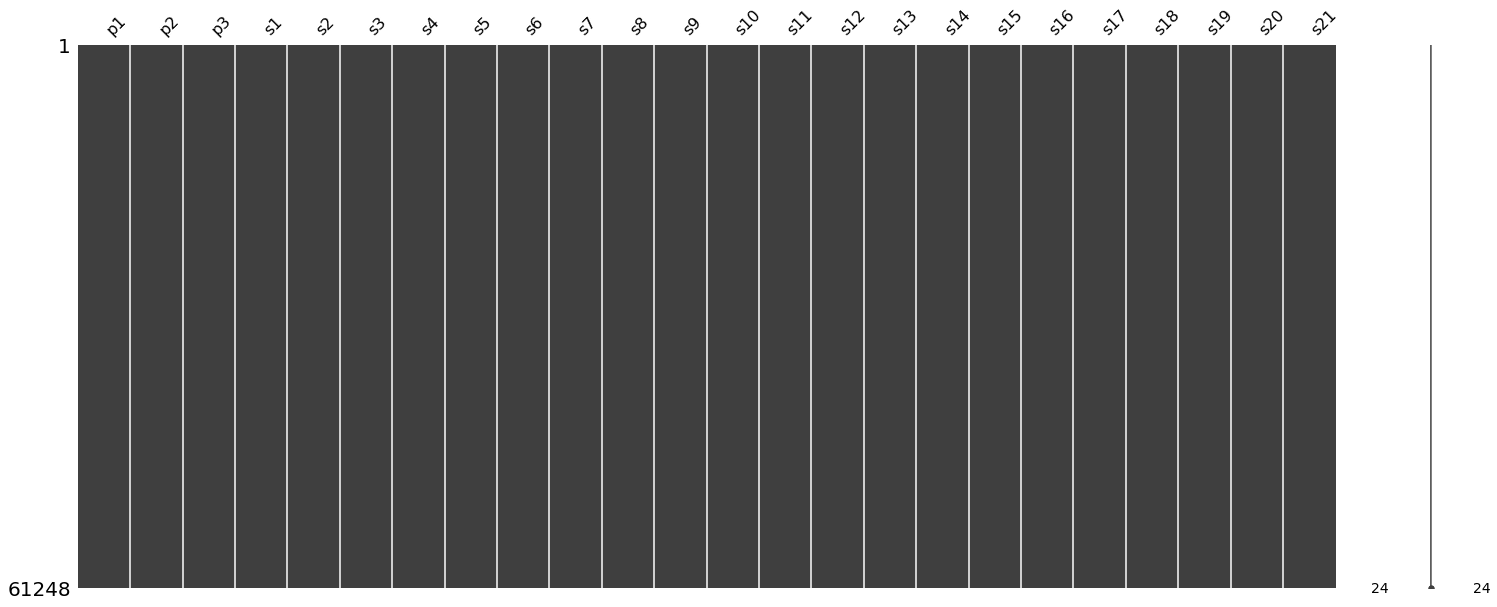

In [8]:
import missingno as msno
%matplotlib inline
msno.matrix(dt[dt_in].sample(61248))
plt.show()

In [9]:
# the nunique() function return number of unique elements in the object. It returns a scalar value which is the count of all the unique values in the Index.
dt[dt_in].nunique()

p1       536
p2       105
p3         2
s1         6
s2      1704
s3     13558
s4     17353
s5         6
s6        46
s7      5926
s8      1038
s9     25297
s10       21
s11      737
s12     5627
s13      483
s14    15938
s15    11915
s16        2
s17       54
s18        6
s19        2
s20      652
s21    21574
dtype: int64

In [10]:
# describe() is used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values.
dt[dt_in].describe()

,p1,p2,p3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,23.997313,0.571251,94.031578,472.930939,579.423035,1417.894897,1201.905518,8.031372,11.590186,283.328217,...,266.737793,2335.209717,8067.666504,9.285586,0.023266,347.758301,2227.973145,97.756859,20.864311,12.518955
std,14.780671,0.310710,14.253440,26.436731,37.342667,106.167366,119.327286,3.623157,5.444033,146.880753,...,138.478836,128.208679,85.670006,0.750363,0.004684,27.807484,145.463654,5.368834,9.936445,5.962700
min,0.000000,0.000000,60.000000,445.000000,535.479980,1242.670044,1024.420044,3.910000,5.670000,136.169998,...,128.309998,2027.569946,7845.779785,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,10.004600,0.250700,100.000000,445.000000,549.330017,1350.550049,1119.489990,3.910000,5.720000,142.919998,...,134.520004,2387.909912,8062.629883,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100
50%,25.001400,0.700000,100.000000,462.540009,555.739990,1367.680054,1136.920044,7.050000,9.030000,194.960007,...,183.449997,2388.060059,8083.810059,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100
75%,41.998100,0.840000,100.000000,491.190002,607.070007,1497.420044,1302.619995,10.520000,15.480000,394.279999,...,371.399994,2388.169922,8128.350098,9.365800,0.030000,368.000000,2324.000000,100.000000,28.559999,17.135500
max,42.007999,0.842000,100.000000,518.669983,644.419983,1613.000000,1440.770020,14.620000,21.610001,570.809998,...,537.489990,2390.489990,8261.650391,11.066300,0.030000,399.000000,2388.000000,100.000000,39.889999,23.885201


## Data Spliting

In [11]:
trs_ratio = 0.03 # Ratio of supervised experiments
tru_ratio = 0.75 # Ration of supervised and unsupervised data

np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep_trs = int(trs_ratio * len(machines))
sep_tru = int(tru_ratio * len(machines))

trs_mcn = list(machines[:sep_trs])
tru_mcn = list(machines[sep_trs:sep_tru])
ts_mcn = list(machines[sep_tru:])

Let's chek how many machines we have in each group:

In [15]:
print(f'Number of machines: {len(trs_mcn)} (supervised), {len(tru_mcn)} (unsupervised), {len(ts_mcn)} (test)')

Number of machines: 7 (supervised), 179 (unsupervised), 63 (test)


we can split the dataset according to this machine groups:

In [16]:
tr, ts = utils.partition_by_machine(dt, trs_mcn + tru_mcn)
trs, tru = utils.partition_by_machine(tr, trs_mcn)

In [17]:
tr

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.004902,0.8400,100.0,445.000000,549.679993,1343.430054,1112.930054,...,2387.989990,8074.830078,9.3335,0.02,330.0,2212.0,100.00,10.620000,6.367000,320
1,train_FD004,461,2,20.002001,0.7002,100.0,491.190002,606.070007,1477.609985,1237.500000,...,2387.729980,8046.129883,9.1913,0.02,361.0,2324.0,100.00,24.370001,14.655200,319
2,train_FD004,461,3,42.003799,0.8409,100.0,445.000000,548.950012,1343.119995,1117.050049,...,2387.969971,8066.620117,9.4007,0.02,329.0,2212.0,100.00,10.480000,6.421300,318
3,train_FD004,461,4,42.000000,0.8400,100.0,445.000000,548.700012,1341.239990,1118.030029,...,2388.020020,8076.049805,9.3369,0.02,328.0,2212.0,100.00,10.540000,6.417600,317
4,train_FD004,461,5,25.006300,0.6207,60.0,462.540009,536.099976,1255.229980,1033.589966,...,2028.079956,7865.799805,10.8366,0.02,305.0,1915.0,84.93,14.030000,8.675400,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60989,train_FD004,708,180,35.001900,0.8409,100.0,449.440002,556.280029,1377.650024,1148.959961,...,2387.770020,8048.910156,9.4169,0.02,337.0,2223.0,100.00,14.660000,8.744600,4
60990,train_FD004,708,181,0.002300,0.0000,100.0,518.669983,643.950012,1602.979980,1429.569946,...,2388.270020,8122.439941,8.5242,0.03,396.0,2388.0,100.00,38.400002,23.107901,3
60991,train_FD004,708,182,25.003000,0.6200,60.0,462.540009,536.880005,1268.010010,1067.089966,...,2027.979980,7865.180176,10.9790,0.02,309.0,1915.0,84.93,14.240000,8.425400,2
60992,train_FD004,708,183,41.998402,0.8414,100.0,445.000000,550.640015,1363.760010,1145.719971,...,2387.479980,8069.839844,9.4607,0.02,333.0,2212.0,100.00,10.370000,6.272700,1


In [18]:
ts

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
321,train_FD004,462,1,41.999802,0.8400,100.0,445.000000,548.989990,1341.819946,1113.160034,...,2387.979980,8082.370117,9.3300,0.02,331.0,2212.0,100.00,10.770000,6.289400,298
322,train_FD004,462,2,9.999900,0.2500,100.0,489.049988,604.229980,1498.000000,1299.540039,...,2388.070068,8125.459961,8.6088,0.03,368.0,2319.0,100.00,28.610001,17.313499,297
323,train_FD004,462,3,42.007900,0.8403,100.0,445.000000,549.109985,1351.469971,1126.430054,...,2387.929932,8082.109863,9.2965,0.02,330.0,2212.0,100.00,10.700000,6.428800,296
324,train_FD004,462,4,42.007702,0.8400,100.0,445.000000,548.770020,1345.810059,1116.640015,...,2387.879883,8079.410156,9.3200,0.02,330.0,2212.0,100.00,10.500000,6.281800,295
325,train_FD004,462,5,24.999901,0.6200,60.0,462.540009,537.000000,1259.550049,1043.949951,...,2028.130005,7867.080078,10.8841,0.02,307.0,1915.0,84.93,14.260000,8.578900,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,train_FD004,709,251,9.999800,0.2500,100.0,489.049988,605.330017,1516.359985,1315.280029,...,2388.729980,8185.689941,8.4541,0.03,372.0,2319.0,100.00,29.110001,17.523399,4
61245,train_FD004,709,252,0.002800,0.0015,100.0,518.669983,643.419983,1598.920044,1426.770020,...,2388.459961,8185.470215,8.2221,0.03,396.0,2388.0,100.00,39.380001,23.715099,3
61246,train_FD004,709,253,0.002900,0.0000,100.0,518.669983,643.679993,1607.719971,1430.560059,...,2388.479980,8193.940430,8.2525,0.03,395.0,2388.0,100.00,39.779999,23.827000,2
61247,train_FD004,709,254,35.004601,0.8400,100.0,449.440002,555.770020,1381.290039,1148.180054,...,2388.830078,8125.640137,9.0515,0.02,337.0,2223.0,100.00,15.260000,9.077400,1


In [19]:
trs

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
1725,train_FD004,467,1,0.002800,0.0003,100.0,518.669983,643.450012,1591.209961,1416.150024,...,2388.149902,8129.950195,8.4689,0.03,394.0,2388.0,100.00,38.869999,23.150700,220
1726,train_FD004,467,2,20.002001,0.7007,100.0,491.190002,607.950012,1477.670044,1253.380005,...,2388.139893,8049.649902,9.2157,0.02,365.0,2324.0,100.00,24.350000,14.665000,219
1727,train_FD004,467,3,0.001300,0.0001,100.0,518.669983,642.849976,1590.359985,1414.859985,...,2388.100098,8124.899902,8.4184,0.03,395.0,2388.0,100.00,38.869999,23.195200,218
1728,train_FD004,467,4,42.004601,0.8400,100.0,445.000000,549.960022,1352.560059,1134.930054,...,2387.810059,8070.799805,9.3901,0.02,332.0,2212.0,100.00,10.600000,6.352700,217
1729,train_FD004,467,5,0.000900,0.0000,100.0,518.669983,642.830017,1596.449951,1407.510010,...,2388.090088,8124.270020,8.4168,0.03,394.0,2388.0,100.00,38.840000,23.374201,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48727,train_FD004,657,166,42.000801,0.8400,100.0,445.000000,550.520020,1366.910034,1142.819946,...,2387.479980,8066.759766,9.4415,0.02,333.0,2212.0,100.00,10.710000,6.389900,4
48728,train_FD004,657,167,42.007599,0.8400,100.0,445.000000,550.320007,1361.250000,1139.819946,...,2387.379883,8069.890137,9.4720,0.02,333.0,2212.0,100.00,10.430000,6.306500,3
48729,train_FD004,657,168,20.007799,0.7000,100.0,491.190002,608.719971,1494.689941,1269.369995,...,2388.179932,8045.220215,9.3182,0.03,369.0,2324.0,100.00,24.170000,14.568200,2
48730,train_FD004,657,169,25.004200,0.6201,60.0,462.540009,537.130005,1269.380005,1058.479980,...,2027.829956,7857.200195,11.0035,0.02,310.0,1915.0,84.93,14.170000,8.414100,1


In [20]:
tru

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,42.004902,0.8400,100.0,445.000000,549.679993,1343.430054,1112.930054,...,2387.989990,8074.830078,9.3335,0.02,330.0,2212.0,100.00,10.620000,6.367000,320
1,train_FD004,461,2,20.002001,0.7002,100.0,491.190002,606.070007,1477.609985,1237.500000,...,2387.729980,8046.129883,9.1913,0.02,361.0,2324.0,100.00,24.370001,14.655200,319
2,train_FD004,461,3,42.003799,0.8409,100.0,445.000000,548.950012,1343.119995,1117.050049,...,2387.969971,8066.620117,9.4007,0.02,329.0,2212.0,100.00,10.480000,6.421300,318
3,train_FD004,461,4,42.000000,0.8400,100.0,445.000000,548.700012,1341.239990,1118.030029,...,2388.020020,8076.049805,9.3369,0.02,328.0,2212.0,100.00,10.540000,6.417600,317
4,train_FD004,461,5,25.006300,0.6207,60.0,462.540009,536.099976,1255.229980,1033.589966,...,2028.079956,7865.799805,10.8366,0.02,305.0,1915.0,84.93,14.030000,8.675400,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60989,train_FD004,708,180,35.001900,0.8409,100.0,449.440002,556.280029,1377.650024,1148.959961,...,2387.770020,8048.910156,9.4169,0.02,337.0,2223.0,100.00,14.660000,8.744600,4
60990,train_FD004,708,181,0.002300,0.0000,100.0,518.669983,643.950012,1602.979980,1429.569946,...,2388.270020,8122.439941,8.5242,0.03,396.0,2388.0,100.00,38.400002,23.107901,3
60991,train_FD004,708,182,25.003000,0.6200,60.0,462.540009,536.880005,1268.010010,1067.089966,...,2027.979980,7865.180176,10.9790,0.02,309.0,1915.0,84.93,14.240000,8.425400,2
60992,train_FD004,708,183,41.998402,0.8414,100.0,445.000000,550.640015,1363.760010,1145.719971,...,2387.479980,8069.839844,9.4607,0.02,333.0,2212.0,100.00,10.370000,6.272700,1


Let's check the number of examples for each group:

In [21]:
print(f'Number of samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Number of samples: 1376 (supervised), 44009 (unsupervised), 15864 (test)


## Standardization and Normalization

Now we can standardize and normalize the input data.

In [22]:
# standardize

trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields

ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = trs.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd
trs_s = trs.copy()
trs_s[dt_in] = (trs_s[dt_in] - trmean) / trstd
tru_s = tru.copy()
tru_s[dt_in] = (tru_s[dt_in] - trmean) / trstd


# normalize

trmaxrul = tr['rul'].max()

ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 
trs_s['rul'] = trs['rul'] / trmaxrul
tru_s['rul'] = tru['rul'] / trmaxrul

In [23]:
nn = models.MLPRegressor(input_shape=len(dt_in), hidden=[32, 32])
nn.compile(optimizer='Adam', loss='mse')

history = nn.fit(trs_s[dt_in], trs_s['rul'], batch_size=32, epochs=20, verbose=1)

Epoch 1/20
43/43 [==============================] - 1s 2ms/step - loss: 0.1503
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0140
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 9/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 11/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 12/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 13/20
43/43 [==============================

## Domain Knowledge as Constraints

We start by preparing a bit more the unsupervised data.

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [24]:
tru_s_by_m = utils.split_by_field(tru_s, 'machine')
np.random.seed(42)
for mcn, tmp in tru_s_by_m.items():
    cutoff = int(np.random.randint(10, 50, 1))
    tru_s_by_m[mcn] = tmp.iloc[:-cutoff]
tru_st = pd.concat(tru_s_by_m.values())

Then we assign an invalid value to the RUL for unsupervised data.

In [25]:
trsu_s = pd.concat((trs_s, tru_st))
trsu_s.loc[tru_st.index, 'rul'] = -1

In [26]:
nn2 = models.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32])
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn2.compile(optimizer='Adam', run_eagerly=False)
history = nn2.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0057 - mse: 0.0013 - cst: 0.0057
Epoch 2/20
1350/1350 [==============================] - 8s 6ms/step - loss: 4.4986e-04 - mse: 0.0010 - cst: 4.4986e-04
Epoch 3/20
1350/1350 [==============================] - 8s 6ms/step - loss: 4.5617e-04 - mse: 8.5413e-04 - cst: 4.5617e-04
Epoch 4/20
1350/1350 [==============================] - 8s 6ms/step - loss: 4.5507e-04 - mse: 8.1457e-04 - cst: 4.5507e-04
Epoch 5/20
1350/1350 [==============================] - 7s 6ms/step - loss: 4.2259e-04 - mse: 8.2040e-04 - cst: 4.2259e-04
Epoch 6/20
1350/1350 [==============================] - 7s 5ms/step - loss: 4.1730e-04 - mse: 8.5758e-04 - cst: 4.1730e-04
Epoch 7/20
1350/1350 [==============================] - 8s 6ms/step - loss: 4.0084e-04 - mse: 0.0010 - cst: 4.0084e-04
Epoch 8/20
1350/1350 [==============================] - 8s 6ms/step - loss: 3.9065e-04 - mse: 0.0013 - cst: 3.9065e-04
Epoch 9/20
1350/1350 [==================

## Lagrangian Duality Approach

In [27]:
nn3 = models.LagDualRULRegressor(input_shape=len(dt_in), maxrul=trmaxrul, hidden=[32, 32])
batch_gen = models.CstBatchGenerator(trsu_s, dt_in, batch_size=32)
cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
nn3.compile(optimizer='Adam', run_eagerly=False)
history = nn3.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)

Epoch 1/20
1350/1350 [==============================] - 8s 6ms/step - loss: -7.5860e-04 - mse: 4.3068e-04 - cst: 0.0024
Epoch 2/20
1350/1350 [==============================] - 7s 5ms/step - loss: -6.9660e-04 - mse: 3.6549e-04 - cst: 6.5532e-04
Epoch 3/20
1350/1350 [==============================] - 7s 5ms/step - loss: -7.9492e-04 - mse: 3.7588e-04 - cst: 4.9584e-04
Epoch 4/20
1350/1350 [==============================] - 8s 6ms/step - loss: -9.2401e-04 - mse: 3.8187e-04 - cst: 4.0791e-04
Epoch 5/20
1350/1350 [==============================] - 8s 6ms/step - loss: -0.0012 - mse: 3.8592e-04 - cst: 3.8931e-04
Epoch 6/20
1350/1350 [==============================] - 7s 5ms/step - loss: -0.0015 - mse: 3.8708e-04 - cst: 3.6958e-04
Epoch 7/20
1350/1350 [==============================] - 7s 5ms/step - loss: -0.0018 - mse: 3.8846e-04 - cst: 3.6330e-04
Epoch 8/20
1350/1350 [==============================] - 7s 5ms/step - loss: -0.0022 - mse: 3.9011e-04 - cst: 3.5579e-04
Epoch 9/20
1350/1350 [======

## Evaluation of Models


### Baseline Approach

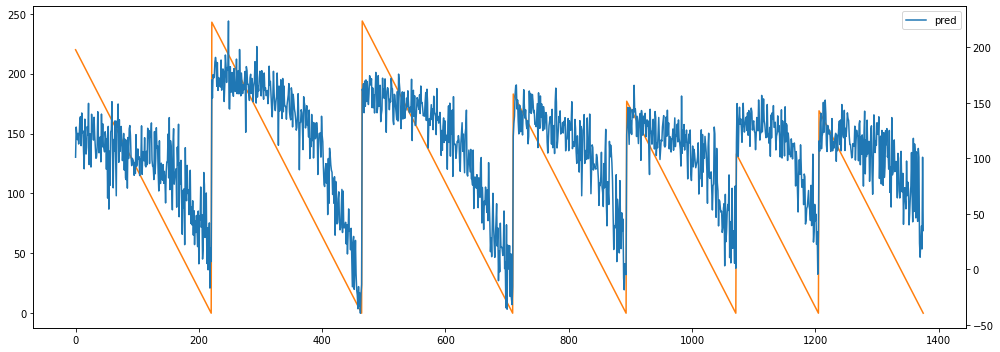

In [28]:
trs_pred = nn.predict(trs_s[dt_in]).ravel() * trmaxrul
stop = 1400 
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Unsupervised data

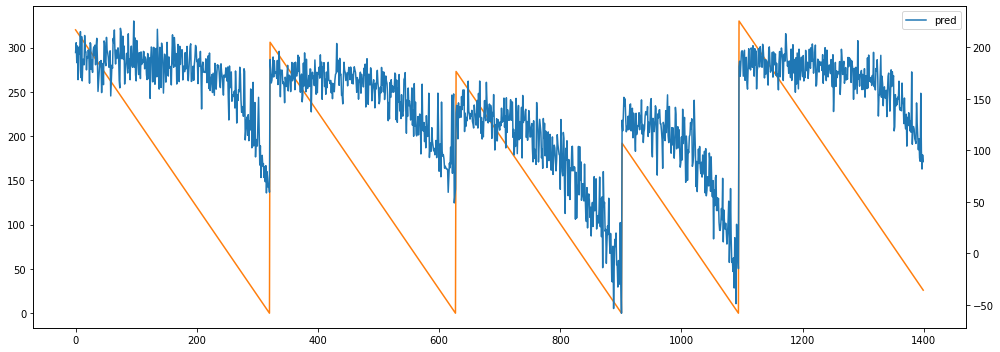

In [29]:
tru_pred = nn.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Test set

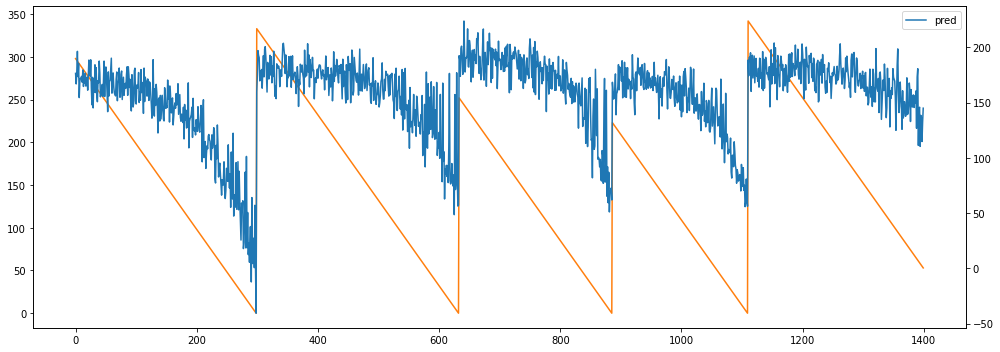

In [30]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Cost Results

Optimal threshold for the training set: 11


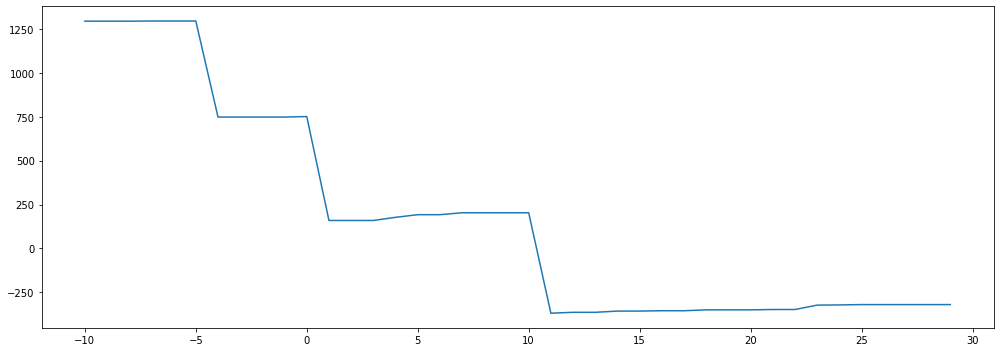

In [31]:
failtimes = dt.groupby('machine')['cycle'].max() 
safe_interval, maintenance_cost = failtimes.min(), failtimes.max()

cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-10, 30)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

### Lagrangian regularizer

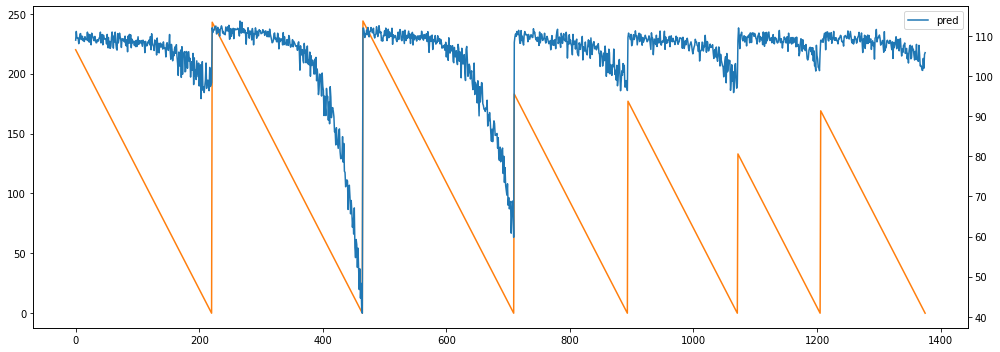

In [32]:
trs_pred = nn3.predict(trs_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(trs_pred[:stop], trs["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Unsupervised data

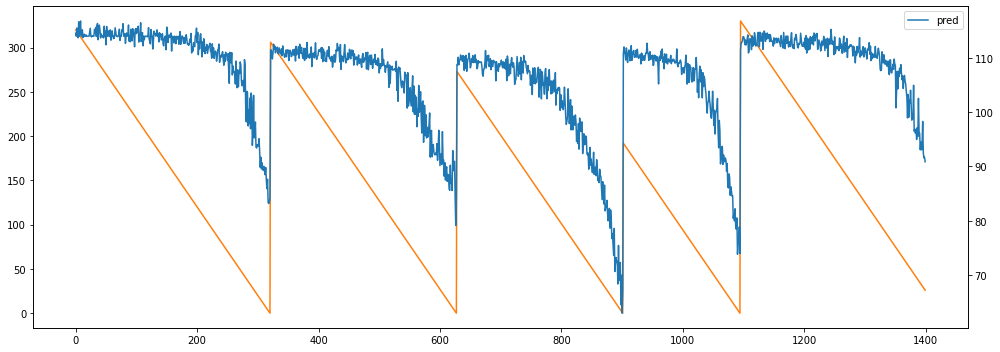

In [33]:
tru_pred = nn3.predict(tru_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(tru_pred[:stop], tru["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Test set

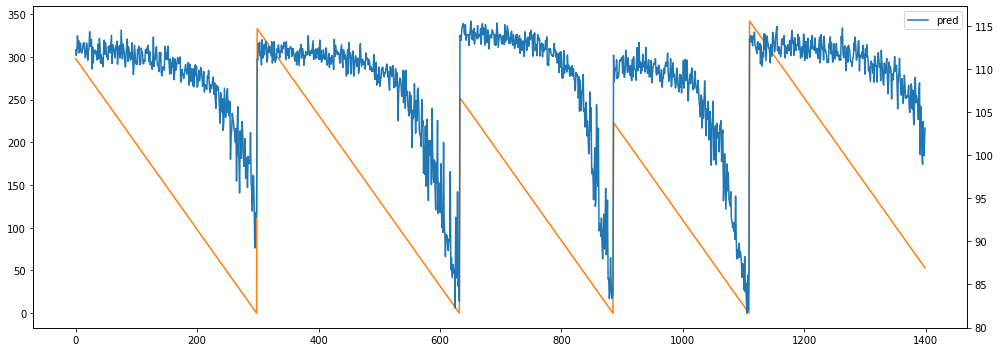

In [34]:
ts_pred = nn3.predict(ts_s[dt_in]).ravel() * trmaxrul
utils.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

#### Cost model

Optimal threshold for the training set: 102


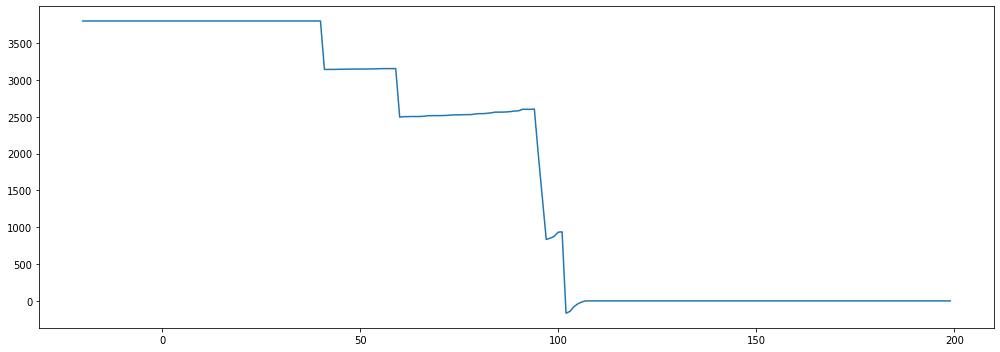

In [35]:
cmodel = models.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(-20, 200)
trs_thr = utils.opt_threshold_and_plot(trs_s['machine'].values, trs_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {trs_thr}')

In [36]:
trs_c, trs_f, trs_sl = cmodel.cost(trs_s['machine'].values, trs_pred, trs_thr, return_margin=True)
tru_c, tru_f, tru_sl = cmodel.cost(tru_s['machine'].values, tru_pred, trs_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, trs_thr, return_margin=True)
print(f'Cost: {trs_c} (supervised), {tru_c} (unsupervised), {ts_c} (test)')

Cost: -167 (supervised), -6663 (unsupervised), -3665 (test)


In [37]:
print(f'Avg. fails: {trs_f/len(trs_mcn):.2f} (supervised), {tru_f/len(tru_mcn):.2f} (unsupervised), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {trs_sl/len(trs_mcn):.2f} (supervised), {tru_sl/len(tru_mcn):.2f} (unsupervised), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (supervised), 0.04 (unsupervised), 0.02 (test)
Avg. slack: 45.00 (supervised), 55.77 (unsupervised), 59.75 (test)
